# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 24.12.2023 23:59 MSK

Жёсткий дедлайн: 24.12.2023 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице


**Оценка**: 4 + 1 + 3 + 2 + 0.5 = 10.5

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
import pandas as pd
!pip install optuna
!pip install catboost

import optuna


sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [ ]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%autoreload 1000000

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [ ]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 1.58 s, sys: 3.68 ms, total: 1.58 s
Wall time: 1.64 s
Train ROC-AUC 0.9897
Valid ROC-AUC 0.9171
Test ROC-AUC 0.9092


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [ ]:
depths = range(1, 30, 2)
train_score = []
test_score = []

for depth in depths:
    base_model_params = {'max_depth': depth}
    model = Boosting(base_model_params)
    model.fit(x_train, y_train, x_test, y_test)
    train_score.append(model.score(x_train, y_train))
    test_score.append(model.score(x_test, y_test))

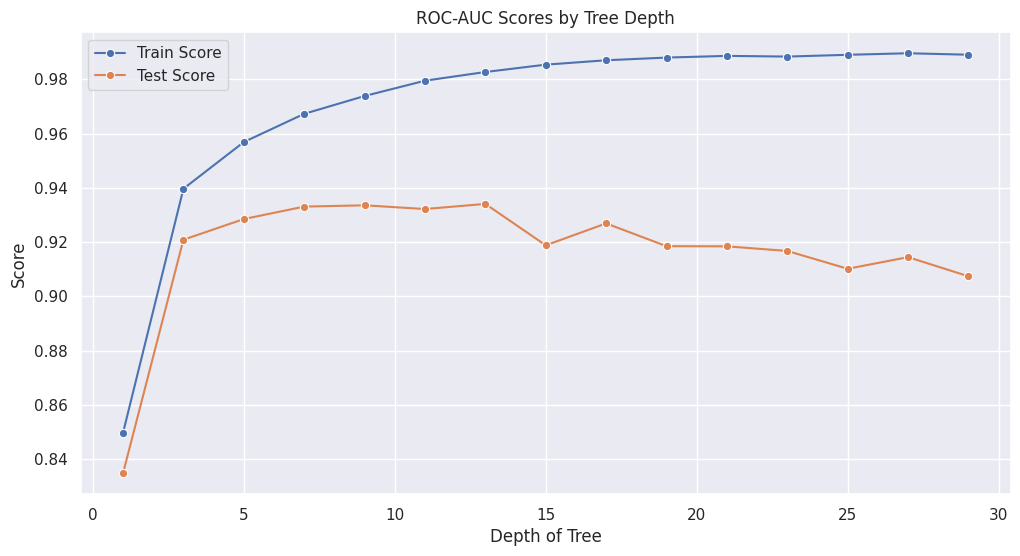

In [ ]:
data = {
    'Depth': list(depths),
    'Train Score': train_score,
    'Test Score': test_score
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))

sns.lineplot(x='Depth', y='Train Score', data=df, label='Train Score', marker='o')

sns.lineplot(x='Depth', y='Test Score', data=df, label='Test Score', marker='o')

plt.title('ROC-AUC Scores by Tree Depth')
plt.xlabel('Depth of Tree')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Синий график равномерно растет. Метрика на тестовой выборке по началу тоже растет, а потому начинает падать. Это может говорить о переобучении дерева с увеличением его глубины. Следует выбрать модель с глубиной, где метрика на тестовой выборке максимальна.

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [ ]:
def objective(trial):
    base_model_params={
        'max_depth': trial.suggest_int("max_depth", 1, 5, step=1),
        'min_samples_split':  trial.suggest_int("min_samples_split", 2, 30, step=2),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 30, step=2)
        }

    n_estimators = trial.suggest_int("n_estimators", 1, 150, step=3)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1)


    model = Boosting(
        base_model_params = base_model_params,
        n_estimators = n_estimators,
        learning_rate = learning_rate
        )

    model.fit(x_train, y_train, x_valid, y_valid)
    score = model.score(x_valid, y_valid)
    return score

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-12-22 13:54:08,203] A new study created in memory with name: no-name-21cc800c-4bb6-415d-93e1-a6ebd0616186
[I 2023-12-22 13:54:10,574] Trial 0 finished with value: 0.9260555876162265 and parameters: {'max_depth': 3, 'min_samples_split': 26, 'min_samples_leaf': 18, 'n_estimators': 94, 'learning_rate': 0.06517040829019641}. Best is trial 0 with value: 0.9260555876162265.
[I 2023-12-22 13:54:11,775] Trial 1 finished with value: 0.9049937222279426 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 12, 'n_estimators': 52, 'learning_rate': 0.038915165464298976}. Best is trial 0 with value: 0.9260555876162265.
[I 2023-12-22 13:54:14,694] Trial 2 finished with value: 0.9229326654071213 and parameters: {'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 24, 'n_estimators': 118, 'learning_rate': 0.03450451386935796}. Best is trial 0 with value: 0.9260555876162265.
[I 2023-12-22 13:54:16,216] Trial 3 finished with value: 0.9293361525438746 and parameter

In [ ]:
best_params = study.best_params
print("Лучшие параметры:", best_params)

best_value = study.best_value
print("Лучшая метрика:", best_value)

Лучшие параметры: {'max_depth': 5, 'min_samples_split': 30, 'min_samples_leaf': 2, 'n_estimators': 148, 'learning_rate': 0.09088677561345929}
Лучшая метрика: 0.9391770491358385


## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
def plot_calibration_curve(ax, y_test, preds, model_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_data = y_test[(preds >= l) & (preds < r)]
        bin_real_ratio = np.mean(bin_data == 1)
        bin_real_ratios.append(bin_real_ratio)
    ax.plot(bin_middle_points, bin_real_ratios, marker='o', label=model_name)
    ax.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='red')

    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel("Predicted Probability")
    ax.set_ylabel("Fraction of Positives")
    ax.set_title("Calibration Curve for " + model_name)
    ax.grid()
    ax.legend()

In [ ]:
def boosting():
    base_model_params={
        'max_depth': best_params.get('max_depth'),
        'min_samples_split': best_params.get('min_samples_split'),
        'min_samples_leaf': best_params.get('min_samples_leaf')
        }

    n_estimators =  best_params.get('n_estimators')
    learning_rate = best_params.get('learning_rate')

    model = Boosting(
        base_model_params = base_model_params,
        n_estimators = n_estimators,
        learning_rate = learning_rate
        )

    model.fit(x_train, y_train, x_valid, y_valid)
    score = model.score(x_test, y_test)
    return model, score

best_boosting, boosting_score = boosting()

In [ ]:
boosting_score

0.9372082258082294

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

LogisticRegression()

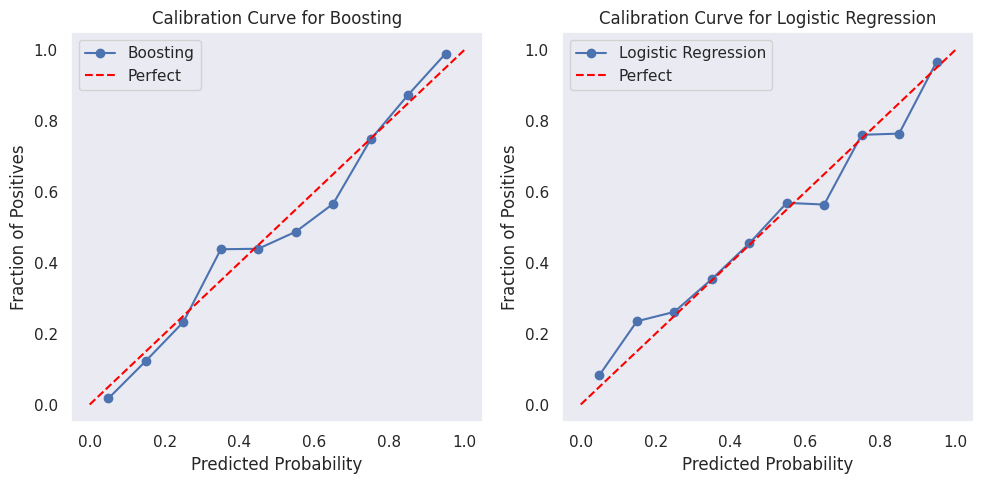

In [ ]:
plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
y_prob_boosting = best_boosting.predict_proba(x_test)[:, 1]
plot_calibration_curve(ax1, y_test, y_prob_boosting, "Boosting")

ax2 = plt.subplot(1, 2, 2)
y_prob_lr = model_lr.predict_proba(x_test)[:, 1]
plot_calibration_curve(ax2, y_test, y_prob_lr, "Logistic Regression")

plt.tight_layout()
plt.show()

**Ответ**: В моем случае обе калибровочные кривые пытаются приблизить идеальную прямую, но местами требуют калибровки.

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

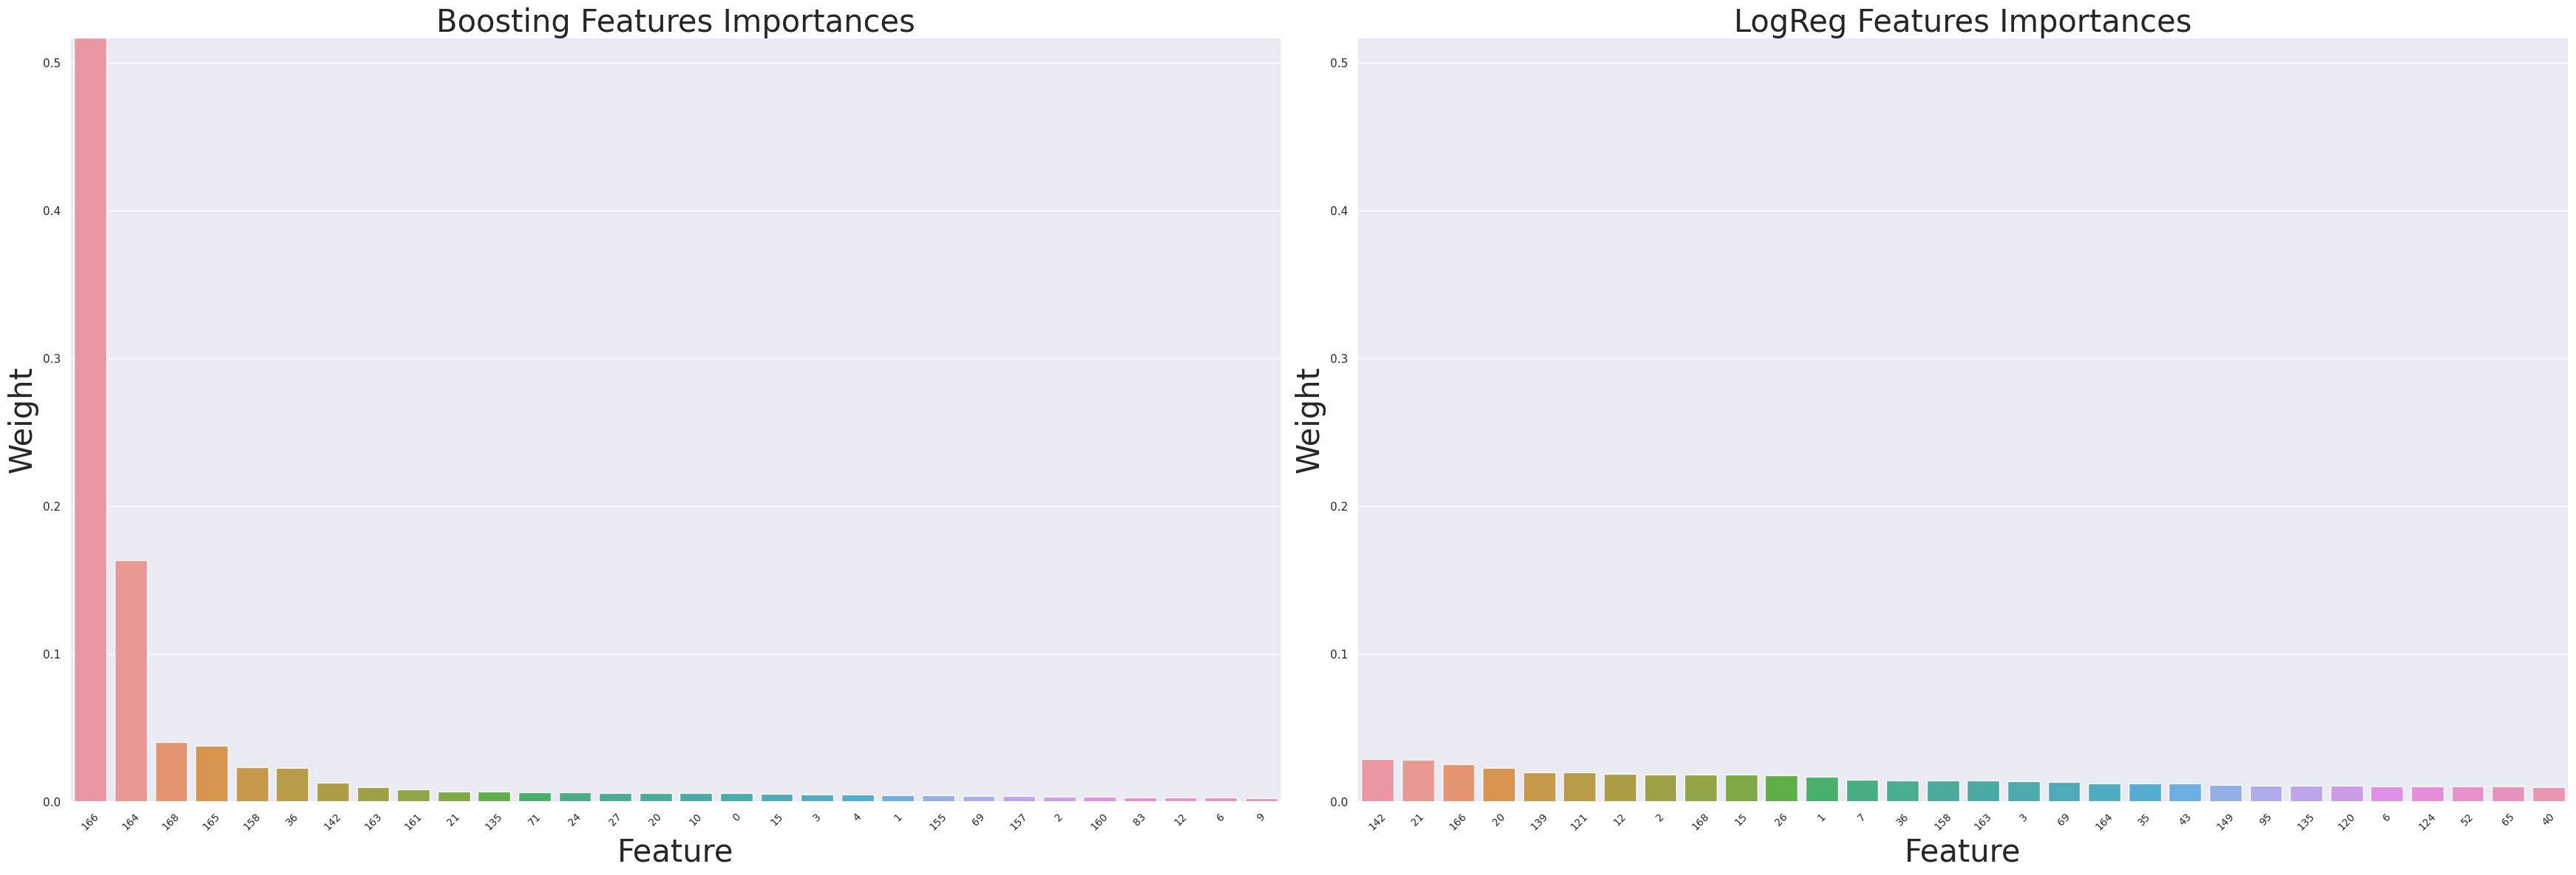

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_feature_importances(best_boosting, model_lr, count):

    fig, axs = plt.subplots(1, 2, figsize=(35, 12))
    size_plot = 30
    range = np.arange(count)

    boosting_weights = best_boosting.feature_importances_
    sorted_indices_boosting = np.argsort(boosting_weights)[::-1][:count]
    boosting_top_fetures = boosting_weights[sorted_indices_boosting]

    sns.barplot(x=range, y=boosting_top_fetures, ax=axs[0])

    axs[0].set_title('Boosting Features Importances', size=size_plot)
    axs[0].set_xticks(range)

    axs[0].set_xticklabels(sorted_indices_boosting, rotation=45, size=10)
    axs[0].set_ylabel('Weight', size=size_plot)
    axs[0].set_xlabel('Feature', size=size_plot)

    lr_weights = np.abs(model_lr.coef_) / np.sum(np.abs(model_lr.coef_))
    sorted_indices_lr = np.argsort(lr_weights[0])[::-1][:count]
    lr_top_features = lr_weights[0][sorted_indices_lr]

    sns.barplot(x=range, y=lr_top_features, ax=axs[1])

    axs[1].set_title('LogReg Features Importances', size=size_plot)
    axs[1].set_xticks(range)
    axs[1].set_xticklabels(sorted_indices_lr, rotation=45, size=10)
    axs[1].set_ylabel('Weight', size=size_plot)
    axs[1].set_xlabel('Feature', size=size_plot)

    max_weight = max(boosting_weights[sorted_indices_boosting].max(), lr_weights[0][sorted_indices_lr].max())
    axs[0].set_ylim(0, max_weight)
    axs[1].set_ylim(0, max_weight)

    plt.tight_layout()
    plt.show()

plot_feature_importances(best_boosting, model_lr, count=30)


Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
boosting_weights = best_boosting.feature_importances_
important_condition = (boosting_weights > np.quantile(boosting_weights, 0.8))

x_train_important = x_train[:, important_condition]
x_valid_important = x_valid[:, important_condition]
x_test_important = x_test[:, important_condition]


def boosting():
    base_model_params={
        'max_depth': best_params.get('max_depth'),
        'min_samples_split': best_params.get('min_samples_split'),
        'min_samples_leaf': best_params.get('min_samples_leaf')
        }

    n_estimators =  best_params.get('n_estimators')
    learning_rate = best_params.get('learning_rate')

    model = Boosting(
        base_model_params = base_model_params,
        n_estimators = n_estimators,
        learning_rate = learning_rate
        )

    model.fit(x_train_important, y_train, x_valid_important, y_valid)
    score = model.score(x_test_important, y_test)
    return model, score

best_boosting_important, boosting_score_important = boosting()
boosting_score_important

0.9374420387861879

**Ответ** В моем случае фильтрация признаков не особо повлияла на метрику.

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
from sklearn.metrics import roc_auc_score

blended_boosting_lr = (y_prob_lr + y_prob_boosting) / 2
print("ROC AUC blended:", roc_auc_score(y_test, blended_boosting_lr))

ROC AUC blended: 0.9410307137357645


**Ответ**: Да, качество улучшилось

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
from catboost import CatBoost, Pool

train_pool = Pool(x_train, y_train)
test_pool = Pool(x_test, y_test)


param = {'iterations': 1000, 'loss_function': 'Logloss', 'learning_rate': 0.1, 'depth': 3}
model = CatBoost(param)
model.fit(train_pool, verbose=False)

preds_proba = model.predict(test_pool, prediction_type='Probability')

positive_class_probs = preds_proba[:, 1]

roc_auc = roc_auc_score(y_test, positive_class_probs)

print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.9422210343508266


**Ответ**: получилось лучше чем моя реализация и чуть лучше чем блендинг. Параметры по умолчанию в CatBoost выдавали примерно тот же результат, что и собственная модель.

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2024 года?

Дорогой Дед Моороз, этот год был сложным, но я успешно справился со всеми трудностями, которые мне преподносила судьба. Фотография с ёлкой на покре будет напоминать мне о счастливых моментах студенчества, которые я разделил вместе с друзьями. Пусть в новом году у нас получится свершить всё задуманное и пусть удача не покидает нас.